# Import and setup variables

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

# Read in test and train cohort pcs

In [2]:
bucket = os.getenv("WORKSPACE_BUCKET")
bucket

'gs://fc-secure-61ffe592-139f-4be1-8b47-8dbe2adbb1eb'

In [3]:
!gsutil cp {bucket}/data/Demographic_and_ancestry_covariates.csv . 
cohort_df = pd.read_csv("Demographic_and_ancestry_covariates.csv") 
cohort_df = cohort_df.drop(columns=[col for col in cohort_df.columns if col.startswith("PC")])
cohort_df = cohort_df.drop(columns=['ancestry_pred'])
cohort_df.info()

Copying gs://fc-secure-61ffe592-139f-4be1-8b47-8dbe2adbb1eb/data/Demographic_and_ancestry_covariates.csv...
\ [1 files][ 79.8 MiB/ 79.8 MiB]                                                
Operation completed over 1 objects/79.8 MiB.                                     
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135611 entries, 0 to 135610
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   person_id                   135611 non-null  int64  
 1   date_of_birth               135611 non-null  object 
 2   AIAN                        135611 non-null  bool   
 3   Asian                       135611 non-null  bool   
 4   Black                       135611 non-null  bool   
 5   Mid                         135611 non-null  bool   
 6   Multiple                    135611 non-null  bool   
 7   PI                          135611 non-null  bool   
 8   White                       13561

In [4]:
!gsutil -u $GOOGLE_PROJECT cp gs://fc-aou-datasets-controlled/v8/wgs/short_read/snpindel/aux/ancestry/ancestry_preds.tsv . 
ancestry = pd.read_csv("ancestry_preds.tsv", sep="\t")
ancestry = ancestry.drop(columns=['probabilities', 'ancestry_pred_other'])
ancestry.info()

Copying gs://fc-aou-datasets-controlled/v8/wgs/short_read/snpindel/aux/ancestry/ancestry_preds.tsv...
/ [1 files][163.4 MiB/163.4 MiB]                                                
Operation completed over 1 objects/163.4 MiB.                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414830 entries, 0 to 414829
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   research_id    414830 non-null  int64 
 1   ancestry_pred  414830 non-null  object
 2   pca_features   414830 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.5+ MB


In [5]:
# --- 1. Remove square brackets from pca_features ---
ancestry['pca_features'] = ancestry['pca_features'].str.replace(r"\[|\]", "", regex=True)

# --- 2. Split into 16 PC columns ---
pc_columns = [f'PC_{i}' for i in range(1, 17)]
pca_split = ancestry['pca_features'].str.split(",", expand=True).astype(float)
pca_split.columns = pc_columns

# Combine with the rest of ancestry dataframe
df_separated = pd.concat([ancestry.drop(columns=['pca_features']), pca_split], axis=1)
df_separated.rename(columns={df_separated.columns[0]: "person_id"}, inplace=True)

# --- 3. Merge with demo data ---
df_combined = df_separated.merge(cohort_df, on="person_id", how="inner")

# --- 4. Split into training and testing ---
#Training on those with WGS but not in our study 
test_pcs_df = df_separated[df_separated['person_id'].isin(cohort_df['person_id'])]
train_pcs_df = df_separated[~df_separated['person_id'].isin(cohort_df['person_id'])]

# --- 5. Print ancestry distribution before sampling ---
print("Before sampling:")
print(train_pcs_df['ancestry_pred'].value_counts())

# --- 6. Stratified downsampling ---
np.random.seed(246)
train_pcs_df = (
    train_pcs_df.groupby('ancestry_pred', group_keys=False)
    .apply(lambda x: x.sample(n=min(4405, len(x)), replace=False)) #select second smallest group 
)

# --- 7. Check result ---
print("After sampling:")
print(train_pcs_df['ancestry_pred'].value_counts())


Before sampling:
ancestry_pred
eur    148961
amr     61239
afr     55260
eas      8268
sas      4405
mid      1086
Name: count, dtype: int64
After sampling:
ancestry_pred
afr    4405
amr    4405
eas    4405
eur    4405
sas    4405
mid    1086
Name: count, dtype: int64


# Fit data to model for each condition 

In [6]:
# function to extract pcs (+ 1 vec) and scores as numpy arrays
def extract_pcs_and_scores(df, pc_indices):
    pcs_np = df[[f'PC_{i}' for i in pc_indices]].to_numpy()
    n_rows = pcs_np.shape[0]
    pcs_np = np.append(np.repeat(1, n_rows).reshape(n_rows, 1), pcs_np, axis = 1)
    scores = df['SCORE'].to_numpy()
    return pcs_np, scores

def extract_standardized_pcs_and_scores(df, pc_indices):
    pcs_np = df[[f'PC_{i}' for i in pc_indices]].to_numpy()
    pcs_np = (pcs_np - np.mean(pcs_np, axis = 0))/np.std(pcs_np, axis = 0)
    n_rows = pcs_np.shape[0]
    pcs_np = np.append(np.repeat(1, n_rows).reshape(n_rows, 1), pcs_np, axis = 1)
    scores = df['SCORE'].to_numpy()
    return pcs_np, scores

# function to predict mean
def f_mu(pcs, theta):
    return np.dot(pcs, theta)

# function to predict variance
def f_var(pcs, theta):
    return np.exp(np.dot(pcs, theta))

# objective function
# returns loss, gradient
def obj(pcs, scores, theta):
    split_index = pcs.shape[1]
    
    theta_mu = theta[:split_index]
    theta_var = theta[split_index:]
    mu = f_mu(pcs, theta_mu)
    var = f_var(pcs, theta_var)
    # loss is - log of normal distribution (with constant log sqrt(2pi) removed)
    loss = np.sum(np.log(np.sqrt(var)) + (1/2)*(scores-mu)**2/var)
    
    #gradient of loss
    mu_coeff = -(scores-mu)/var
    sig_coeff = 1/2 - (1/2)*(scores-mu)**2/var
    grad = np.append(np.sum(pcs * mu_coeff[:,np.newaxis], axis=0), np.sum(pcs * sig_coeff[:, np.newaxis], axis=0))
    
    return loss, grad

def obj_L1(pcs, scores, theta, l):
    unreg_loss, unreg_grad = obj(pcs, scores, theta)
    loss = unreg_loss + l*np.sum(np.abs(theta))
    grad = unreg_grad + l*np.sign(theta)
    return loss, grad

def adjust_scores(pcs, scores, theta):
    split_index = pcs.shape[1]
    
    theta_mu = theta[:split_index]
    theta_var = theta[split_index:]
    mu = f_mu(pcs, theta_mu)
    var = f_var(pcs, theta_var)
    
    adjusted_scores = (scores - mu)/np.sqrt(var)
    return adjusted_scores


In [7]:
from scipy.optimize import minimize

conditions = ["asthma",
                "atrial_fibrilation",
                "breast_cancer",
                "ckd",
                "coronary_heart_disease",
                "hypercholesterolemia",
                "prostate_cancer",
                "t1d",
                "t2d"]

train_pcs_df = train_pcs_df.rename(columns={"person_id": "IID"}).set_index("IID")
test_pcs_df = test_pcs_df.rename(columns={"person_id": "IID"}).set_index("IID")

train_adjusted_scores_dfs = []
test_adjusted_scores_dfs = []
for condition in conditions:
    # load scores
    !gsutil cp gs://fc-secure-61ffe592-139f-4be1-8b47-8dbe2adbb1eb/data/combined_{condition}.txt .
    scores = pd.read_csv(f"combined_{condition}.txt", usecols=[0, 3], sep=",", index_col="IID")
    train_scores_and_pcs = scores.join(train_pcs_df, how="inner")
    test_scores_and_pcs = scores.join(test_pcs_df, how="inner")
    
    n_pcs = 16
    train_pcs, train_scores = extract_pcs_and_scores(train_scores_and_pcs, range(1, n_pcs + 1))
    x0 = np.append(np.append(train_scores.mean(), np.repeat(0, n_pcs)), 
                   np.append(np.log(train_scores.var()), np.repeat(0, n_pcs))
                  )
    res = minimize(lambda theta : obj(train_pcs, train_scores, theta), x0, method="BFGS", jac=True)
    test_pcs, test_scores = extract_pcs_and_scores(test_scores_and_pcs, range(1, n_pcs + 1))
    
    adjusted_train_scores = adjust_scores(train_pcs, train_scores, res.x)
    adjusted_test_scores = adjust_scores(test_pcs, test_scores, res.x)
    
    df_train_adjusted = train_scores_and_pcs.copy()[["ancestry_pred", "SCORE"]]
    df_train_adjusted["adjusted_score"] = adjusted_train_scores
    df_train_adjusted["condition"] = condition
    
    df_test_adjusted = test_scores_and_pcs.copy()[["ancestry_pred", "SCORE"]]
    df_test_adjusted["adjusted_score"] = adjusted_test_scores
    df_test_adjusted["condition"] = condition
    
    train_adjusted_scores_dfs.append(df_train_adjusted)
    test_adjusted_scores_dfs.append(df_test_adjusted)
    
train_adjusted_scores = pd.concat(train_adjusted_scores_dfs)
test_adjusted_scores = pd.concat(test_adjusted_scores_dfs)
    
    

Copying gs://fc-secure-61ffe592-139f-4be1-8b47-8dbe2adbb1eb/data/combined_asthma.txt...
/ [1 files][ 13.8 MiB/ 13.8 MiB]                                                
Operation completed over 1 objects/13.8 MiB.                                     
Copying gs://fc-secure-61ffe592-139f-4be1-8b47-8dbe2adbb1eb/data/combined_atrial_fibrilation.txt...
/ [1 files][  9.8 MiB/  9.8 MiB]                                                
Operation completed over 1 objects/9.8 MiB.                                      
Copying gs://fc-secure-61ffe592-139f-4be1-8b47-8dbe2adbb1eb/data/combined_breast_cancer.txt...
/ [1 files][ 10.3 MiB/ 10.3 MiB]                                                
Operation completed over 1 objects/10.3 MiB.                                     
Copying gs://fc-secure-61ffe592-139f-4be1-8b47-8dbe2adbb1eb/data/combined_ckd.txt...
/ [1 files][ 13.6 MiB/ 13.6 MiB]                                                
Operation completed over 1 objects/13.6 MiB.                  

# Examine resulting distrbutions

First, we note that the raw PRS scores are distributed differently for different ancesties

In [19]:
g = sns.FacetGrid(train_adjusted_scores, col='condition', hue = "ancestry_pred", 
                  col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x='SCORE', common_norm=False)
g.add_legend()
g.set_titles(col_template="{col_name}")

# Adjust layout and save the figure
plt.tight_layout()
output_path = "pre_adjusted_score_density.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Saved plot to: {output_path}")

Saved plot to: pre_adjusted_score_density.png


Next we look at the adjusted scores for the training cohort.  We note that these are well distributed as standard normal

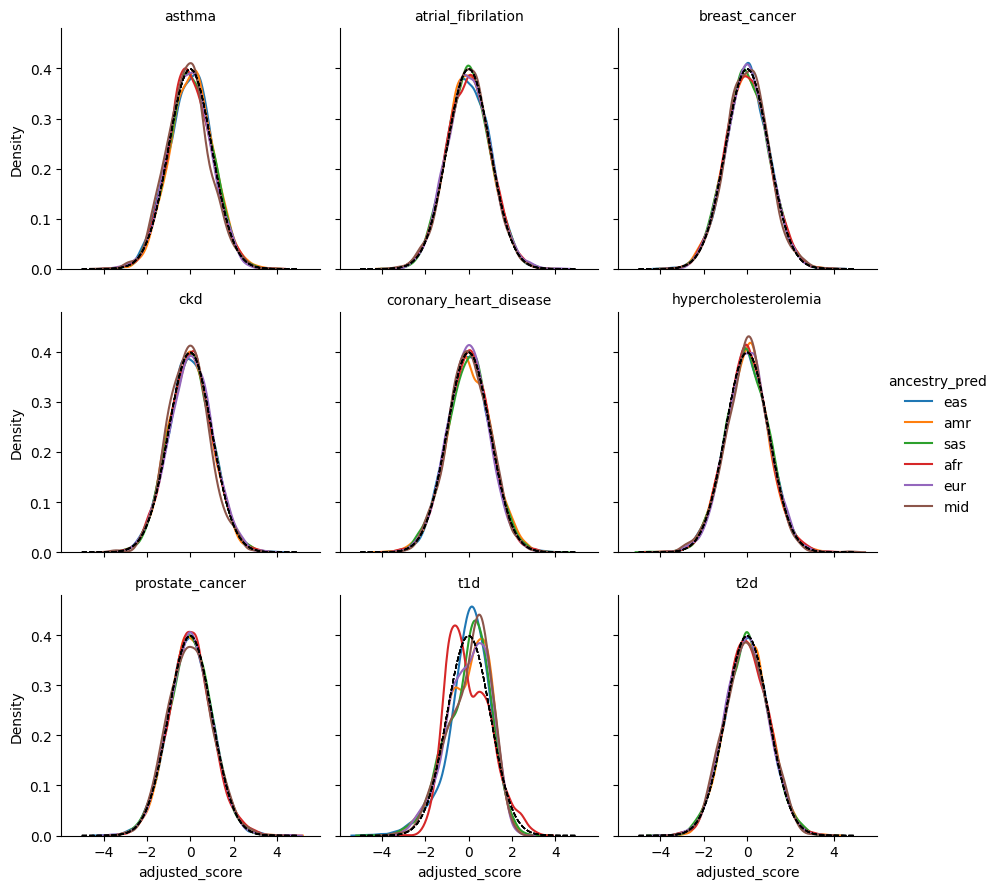

In [9]:
from scipy.stats import norm
import matplotlib.pyplot as plt


def map_pdf(x, **kwargs):
    x_pdf = np.linspace(-5, 5, 100)
    y_pdf = norm.pdf(x_pdf)
    plt.plot(x_pdf, y_pdf, c='k', lw=1, ls="dashed")
    
g = sns.FacetGrid(train_adjusted_scores, col='condition', hue = "ancestry_pred", 
                  col_wrap=3)
g.map_dataframe(sns.kdeplot, x='adjusted_score', common_norm=False)
g.map(map_pdf, 'adjusted_score')
g.add_legend()
g.set_titles(col_template="{col_name}")

We see similar results on the test cohort

In [18]:
def map_pdf(x, **kwargs):
    x_pdf = np.linspace(-5, 5, 100)
    y_pdf = norm.pdf(x_pdf)
    plt.plot(x_pdf, y_pdf, c='k', lw=1, ls="dashed")
    
g = sns.FacetGrid(test_adjusted_scores, col='condition', hue = "ancestry_pred", 
                  col_wrap=3)
g.map_dataframe(sns.kdeplot, x='adjusted_score', common_norm=False)
g.map(map_pdf, 'adjusted_score')
g.add_legend()
g.set_titles(col_template="{col_name}")

# Adjust layout and save the figure
plt.tight_layout()
output_path = "adjusted_score_density.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"Saved plot to: {output_path}")

Saved plot to: adjusted_score_density.png


q-q plots of the test cohort tell the same story.

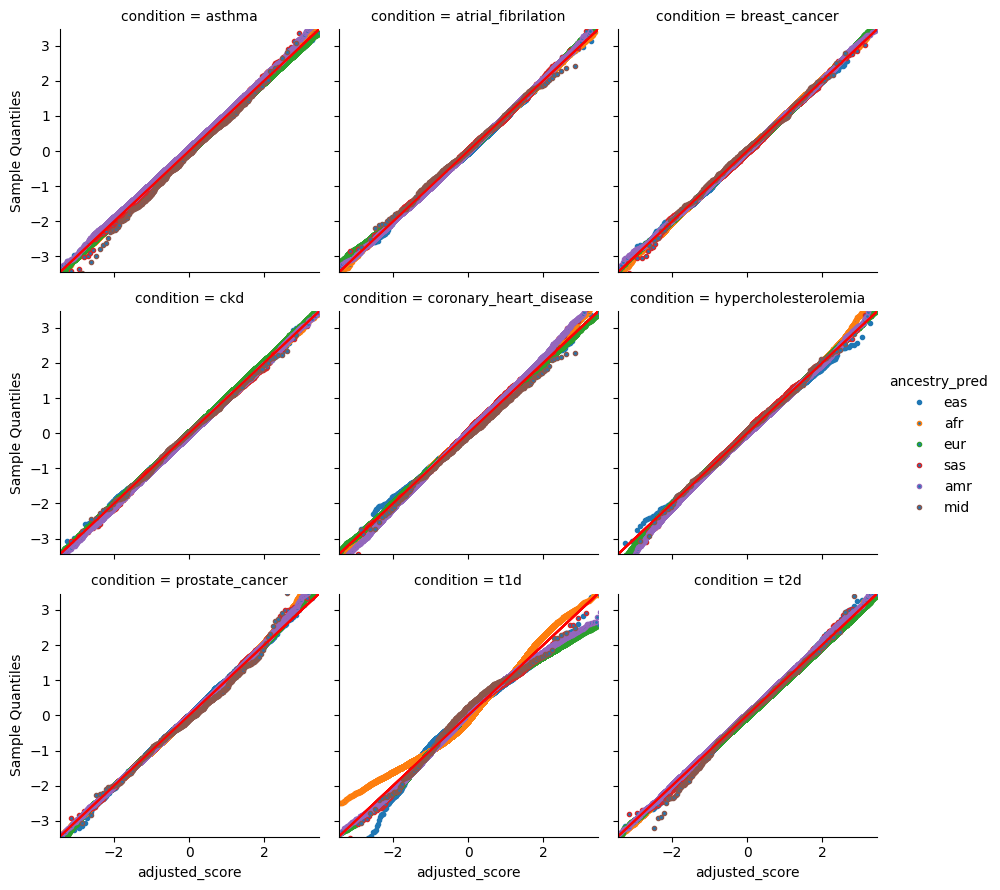

In [11]:
import statsmodels.api as sm

g = sns.FacetGrid(test_adjusted_scores, col='condition', 
                  col_wrap=3, hue='ancestry_pred')


def qqplot_new(x, ax=None, **kwargs):
    kwargs['data']=kwargs.pop('data')[x]
    kwargs['markeredgecolor'] = kwargs.pop('color')
    if ax is None:
        ax = plt.gca()
    sm.qqplot(ax=ax, marker='.', **kwargs, line='45')

g.map_dataframe(qqplot_new, "adjusted_score")
g.add_legend()

# Scale

In [12]:
test_adjusted_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1220499 entries, 3985430 to 2420826
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ancestry_pred   1220499 non-null  object 
 1   SCORE           1220499 non-null  float64
 2   adjusted_score  1220499 non-null  float64
 3   condition       1220499 non-null  object 
dtypes: float64(2), object(2)
memory usage: 46.6+ MB


In [13]:
test_adjusted_scores = test_adjusted_scores.reset_index().rename(columns={"IID": "person_id"})

wide_df = test_adjusted_scores.pivot(index="person_id", columns="condition", values="adjusted_score")
wide_df.columns = [f"{col}_adjusted_score" for col in wide_df.columns]
wide_df = wide_df.reset_index().rename(columns={"IID": "person_id"})

wide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135611 entries, 0 to 135610
Data columns (total 10 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   person_id                              135611 non-null  int64  
 1   asthma_adjusted_score                  135611 non-null  float64
 2   atrial_fibrilation_adjusted_score      135611 non-null  float64
 3   breast_cancer_adjusted_score           135611 non-null  float64
 4   ckd_adjusted_score                     135611 non-null  float64
 5   coronary_heart_disease_adjusted_score  135611 non-null  float64
 6   hypercholesterolemia_adjusted_score    135611 non-null  float64
 7   prostate_cancer_adjusted_score         135611 non-null  float64
 8   t1d_adjusted_score                     135611 non-null  float64
 9   t2d_adjusted_score                     135611 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 10.3 MB


In [14]:
from sklearn.preprocessing import MinMaxScaler

# Identify adjusted_score columns
score_cols = [col for col in wide_df.columns if col.endswith("_adjusted_score")]

# Initialize the scaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected columns
wide_df[score_cols] = scaler.fit_transform(wide_df[score_cols])

# Preview the result
wide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135611 entries, 0 to 135610
Data columns (total 10 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   person_id                              135611 non-null  int64  
 1   asthma_adjusted_score                  135611 non-null  float64
 2   atrial_fibrilation_adjusted_score      135611 non-null  float64
 3   breast_cancer_adjusted_score           135611 non-null  float64
 4   ckd_adjusted_score                     135611 non-null  float64
 5   coronary_heart_disease_adjusted_score  135611 non-null  float64
 6   hypercholesterolemia_adjusted_score    135611 non-null  float64
 7   prostate_cancer_adjusted_score         135611 non-null  float64
 8   t1d_adjusted_score                     135611 non-null  float64
 9   t2d_adjusted_score                     135611 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 10.3 MB


In [15]:
wide_df.columns = [
    "person_id", 
    "Asthma_adjusted_score", 
    "Afib_adjusted_score", 
    "BreastC_adjusted_score", 
    "CKD_adjusted_score",
    "CHD_adjusted_score",  
    "HyperC_adjusted_score", 
    "ProstateC_adjusted_score", 
    "t1d_adjusted_score",
    "t2d_adjusted_score"
]

In [16]:
import os
import subprocess
import numpy as np
import pandas as pd




In [17]:
# This snippet assumes you run setup first

# This code saves your dataframe into a csv file in a "data" folder in Google Bucket

# Replace df with THE NAME OF YOUR DATAFRAME
my_dataframe = wide_df   

# Replace 'test.csv' with THE NAME of the file you're going to store in the bucket (don't delete the quotation marks)
destination_filename = 'adjusted_PRS_scores.csv'

########################################################################
##
################# DON'T CHANGE FROM HERE ###############################
##
########################################################################

# save dataframe in a csv file in the same workspace as the notebook
my_dataframe.to_csv(destination_filename, index=False)

# get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')

# copy csv file to the bucket
args = ["gsutil", "cp", f"./{destination_filename}", f"{my_bucket}/data/"]
output = subprocess.run(args, capture_output=True)

# print output from gsutil
output.stderr


b'Copying file://./adjusted_PRS_scores.csv [Content-Type=text/csv]...\n/ [0 files][    0.0 B/ 23.3 MiB]                                                \r-\r- [0 files][  3.1 MiB/ 23.3 MiB]                                                \r\\\r\\ [0 files][  4.9 MiB/ 23.3 MiB]                                                \r|\r/\r/ [0 files][  6.7 MiB/ 23.3 MiB]                                                \r-\r- [0 files][  8.5 MiB/ 23.3 MiB]                                                \r\\\r|\r| [0 files][ 10.3 MiB/ 23.3 MiB]                                                \r/\r/ [0 files][ 12.1 MiB/ 23.3 MiB]                                                \r-\r- [0 files][ 13.9 MiB/ 23.3 MiB]                                                \r\\\r|\r| [0 files][ 15.7 MiB/ 23.3 MiB]                                                \r/\r/ [0 files][ 17.5 MiB/ 23.3 MiB]                                                \r-\r\\\r\\ [0 files][ 19.3 MiB/ 23.3 MiB]                             